In [3]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
import numpy as np

to run this notebook, astropy is required
this notebook is designed to run with python2.7 using the configuration
described in this LIGO tutorial:
https://www.gw-openscience.org/static/workshop2/course.html
Instructions to install and configure python correctly are included in the preamble
to the tutorial described above

import the module I have written for you to 

In [4]:
import gen_skydir as gs

Generate angles using the sampler function, but do not save to file, just 
save them in the computer memory
NOTE: every time you re-run this cell you will generate new samples
These are in radians - you can convert them to degrees or RA and DEC as needed (see below)

In [5]:
angles = gs.gen_uniform_sphere_sample(10, savetofile = False)

generated 10 sky direction samples


This next piece of code generates a Mollweide projected map of the locations generated above
on the sky

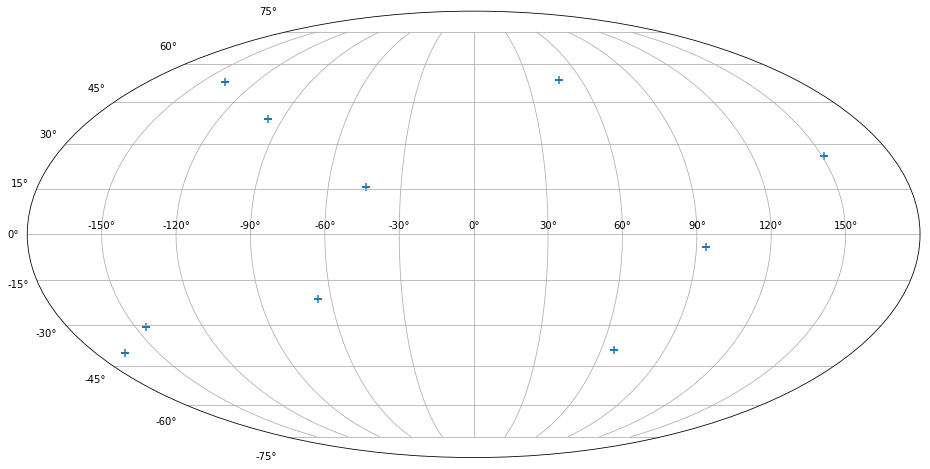

In [6]:
# plot the sky positions you have generated 
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(angles[:,0], angles[:,1], marker='+', s=50)
ax.grid(True)
plt.savefig('skydirections.png')

generate 10 sky positions using the sampler function, and save them to a file called
'anglesout.txt'
NOTE: every time you re-run this cell you will generate new samples, so these samples will
differ from those above!

In [7]:
angles = gs.gen_uniform_sphere_sample(10, savetofile = True, fname = 'anglesout.txt')

You can re-import this file using the numpy.loadtxt function

In [8]:
angles_from_file = np.loadtxt('anglesout.txt')
print(angles_from_file)

[[ 0.1229482  -0.28664077]
 [ 1.93086982 -0.51914892]
 [-0.82184854  0.18636043]
 [-0.50645538  1.40043127]
 [ 1.51634996 -0.77446081]
 [-3.02167427  0.63084518]
 [-0.95420229  0.27428198]
 [-2.47335385  0.22996466]
 [-0.24770522 -0.21687316]
 [-1.45650995 -0.14266437]]


Converting these angles to degrees using astropy

In [9]:
from astropy import units
from astropy.coordinates import SkyCoord

In [10]:
angles_deg = SkyCoord(ra=angles_from_file[:,0]*units.radian,
                      dec=angles_from_file[:,1]*units.radian,
                     frame = 'icrs')

print(angles_deg)

<SkyCoord (ICRS): (ra, dec) in deg
    [(  7.044413  , -16.4233061 ), (110.63069175, -29.74504201),
     (312.91154727,  10.67766619), (330.98224428,  80.23880122),
     ( 86.88045305, -44.37333559), (186.87081725,  36.14476657),
     (305.32823588,  15.71519988), (218.28726304,  13.17600442),
     (345.80753625, -12.42591677), (276.54812715,  -8.17406648)]>


More astropy functionality here https://docs.astropy.org/en/stable/coordinates/

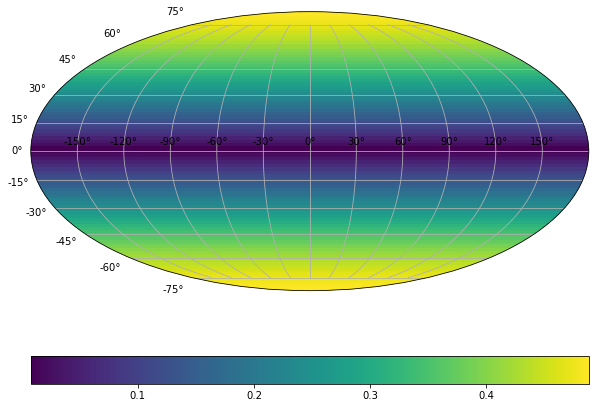

In [13]:
#spherical harmonics

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.special import sph_harm

x = np.linspace(-np.pi, np.pi, 100)
y = np.linspace(-np.pi/2, np.pi/2, 100)
X, Y = np.meshgrid(x, y)

# Spherical coordinate arrays derived from x, y
# Necessary conversions to get Mollweide right
phi = x.copy()    # physical copy
phi[x < 0] = 2 * np.pi + x[x<0]
theta = np.pi/2 - y
PHI, THETA = np.meshgrid(phi, theta)

l, m = 1, 0

# take the absolute value so that it is an actual dipole
SH_SP = abs(sph_harm(m,l, PHI, THETA).real)

# The Cartesian coordinates of the unit sphere
fig, ax = plt.subplots(subplot_kw=dict(projection='mollweide'), figsize=(10,8))
im = ax.pcolormesh(X, Y , SH_SP)
ax.grid()
fig.colorbar(im, orientation='horizontal');

#every pixel is a weight of how likely you are to see a source in that pixel
#

In [12]:
# u = np.random.uniform(0,1, size=10)
# v = np.random.uniform(0,1, size=10)
# alpha = 0.1
# phi = 2*np.pi*u
# theta = np.arccos(alpha*2*v-1)
# theta = [i-np.pi/2 for i in theta]


# print(4*np.pi/3)
# #print(phi, theta)

# c = SkyCoord(ra=phi*units.radian, dec=theta*units.radian, frame='icrs')
# ra = c.ra
# #the sky is weird so wrap the angles at 180 degrees
# ra = ra.wrap_at(180*units.degree)
# dec = c.dec
# out = np.column_stack([ra.radian, dec.radian])

# fig = plt.figure(figsize=(16, 12))
# ax = fig.add_subplot(111, projection="mollweide")
# ax.scatter(out[:,0], out[:,1], marker='+', s=50)
# ax.grid(True)
# #plt.savefig('skydirections.png')

This is a very hacky way to generate points with a dipole using rejection sampling

In [29]:
#use scipy.interpolate to create a function describing how the dipole density changes as a
#function of declination
from scipy.interpolate import interp1d

#This will only work when the spherical harmonic is invariant under rotations in 
#phi
dipole_amp = [abs(SH_SP[i][0]) for i in range(0, 100)]
dec_range = np.linspace(-np.pi/2, np.pi/2, 100)

f = interp1d(dec_range, dipole_amp)

def gen_dipole_sphere(n_samples, savetofile = False, fname = 'none'):
    #get the right ascension
    u = np.random.uniform(0,1, size=n_samples)
    phi = 2*np.pi*u
    
    ### REJECTION SAMPLING ###
    # This basically generates a theta and a random number between 
    # min(dipole_amp) and max(dipole_amp). If this random number is larger than
    # the computed weight of the spherical harmonic at that weight, it is rejected
    
    #save the declination values
    theta = []
    #save the computed amplitudes?
    qsave = []
    while len(theta)<n_samples:
        p = np.random.uniform(-np.pi/2, np.pi/2)
        q = np.random.uniform(min(plot_dec), max(plot_dec))
        if q<f(p):
            theta.append(p)
            qsave.append(q)

    print(theta)
    c = SkyCoord(ra=phi*units.radian, dec=theta*units.radian, frame='icrs')
    ra = c.ra
    #the sky is weird so wrap the angles at 180 degrees
    ra = ra.wrap_at(180*units.degree)
    dec = c.dec
    out = np.column_stack([ra.radian, dec.radian])
    
    if savetofile==True:
        if fname == 'none':
            raise ValueError('invalid file name')
        else:
            np.savetxt(fname, out)
    else:
        print('generated {} sky direction samples'.format(n_samples))
        
    return out

angles = gen_dipole_sphere(1000, savetofile = False, fname = 'none')

[1.5367040921134714, 0.5970425114198195, -1.2682503657966162, -0.8119880093549445, 0.7698568857873211, 0.9680771758378288, 0.6722037375594128, 1.3764314059065952, 1.336953476129167, -1.4158197020312757, -1.4443566397058842, 1.1491101297167647, -0.8729642137610247, 0.5200190858169149, -1.5688765634251305, -0.9459270530177479, 0.8138039162374251, -1.5129199422473965, -0.724452460596534, -0.4064620738652125, 1.1850185150300971, -1.3496800525503774, 0.4917771279332519, -0.08186502065113666, -1.1990912097525839, -0.33884788439540015, -1.426987895442884, -0.973508675221568, -1.3735845422487465, 1.2939653662612023, -1.0776288063505182, 0.697938562278376, -0.4929270623675006, -0.9461324800913725, -1.453471044125619, 0.8871119215041472, -0.9465584408495846, -1.2989139261578218, -0.9157512224853128, -1.0392726056013168, -0.8956085961407655, 0.5649053762069554, -0.8828624422740491, 0.8289037992631996, -1.3922343371590296, -1.050097238258367, -1.4423583105662618, 1.3069716882313491, -1.46930133567

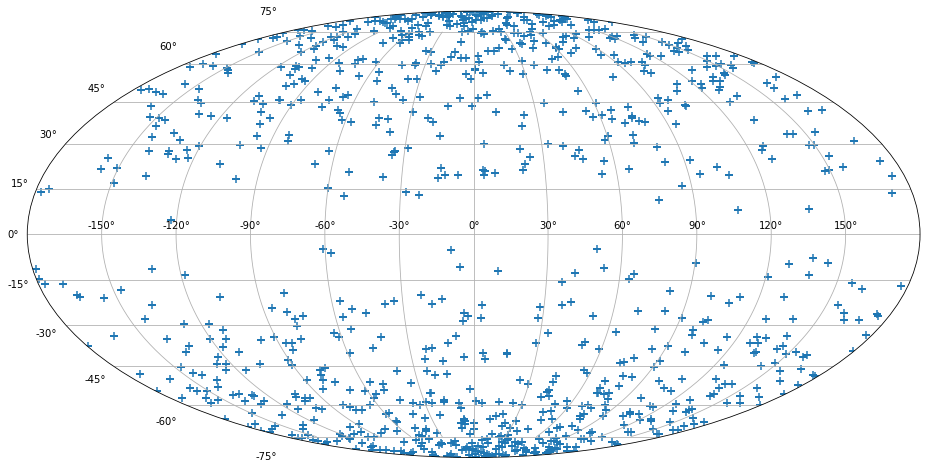

In [30]:
# plot the sky positions you have generated 
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(angles[:,0], angles[:,1], marker='+', s=50)
ax.grid(True)
plt.savefig('skydirections.png')